# Importing Dataset and Libraries
---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Machien Learning
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score, accuracy_score
from imblearn.over_sampling import SMOTE
import optuna
import shap

# Random State
RANDOM_STATE = 1805
pd.set_option('display.max_columns', None)  # or 1000

In [10]:
app = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv',encoding = 'utf-8')
credit = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv',encoding = 'utf-8')

# Data Description
---

## 1. Credit Dataframe

In [3]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [4]:
credit.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


### Categorical
**BAD (0)**
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 

**GOOD (1)**
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- C: paid off that month 
- X: No loan for the month

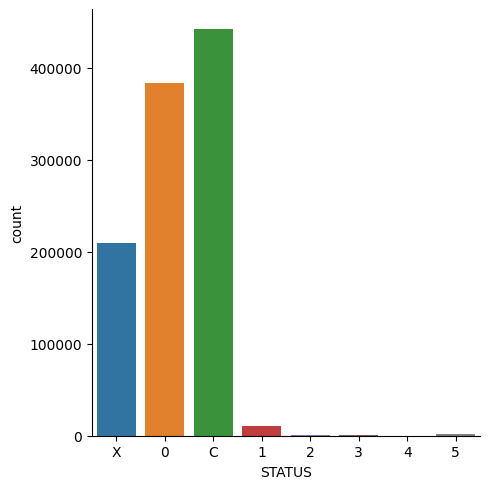

In [14]:
sns.catplot(kind='count',data=credit,x='STATUS')
plt.show()

In [114]:
cpunt=credit.groupby('ID').count()


MONTHS_BALANCE    False
STATUS            False
dtype: bool

## 2. Application Dataframe

In [3]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [22]:
app.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [84]:
app.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


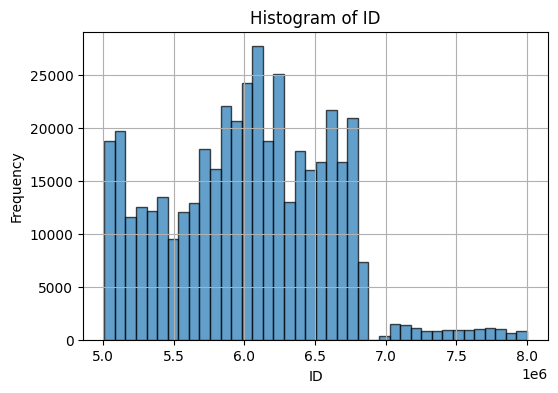

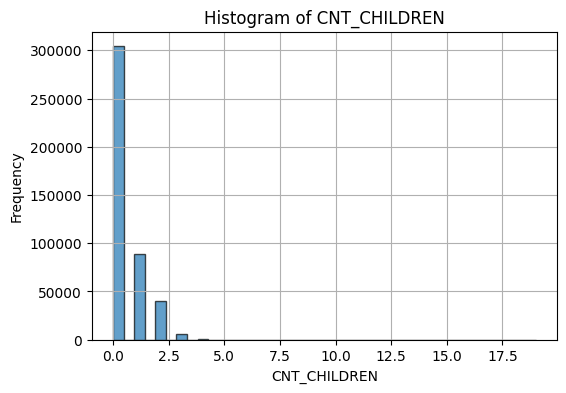

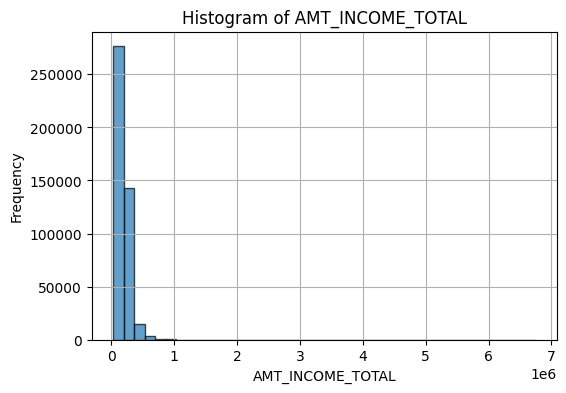

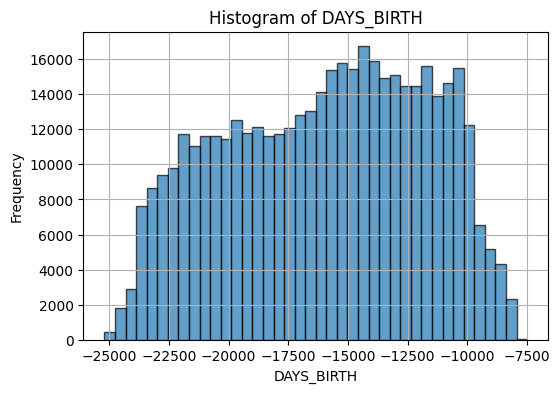

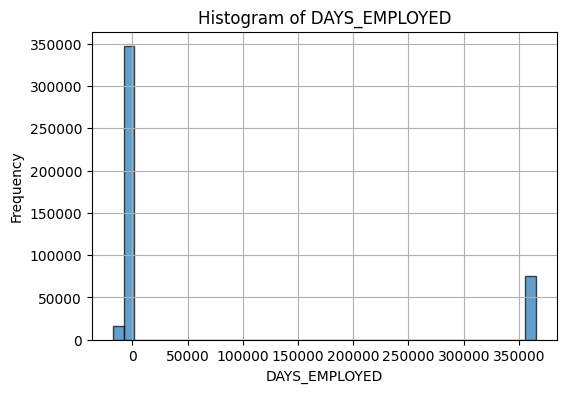

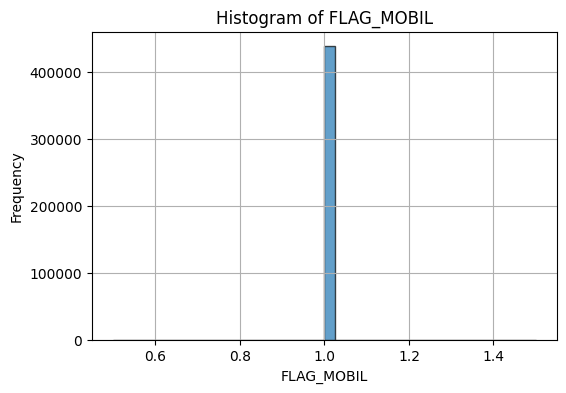

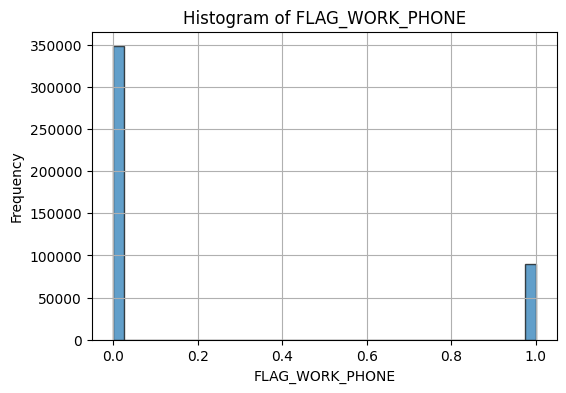

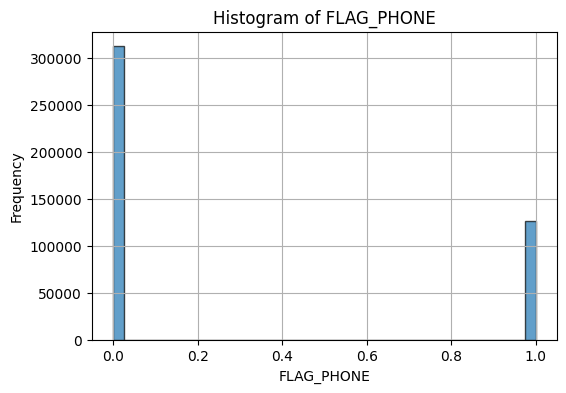

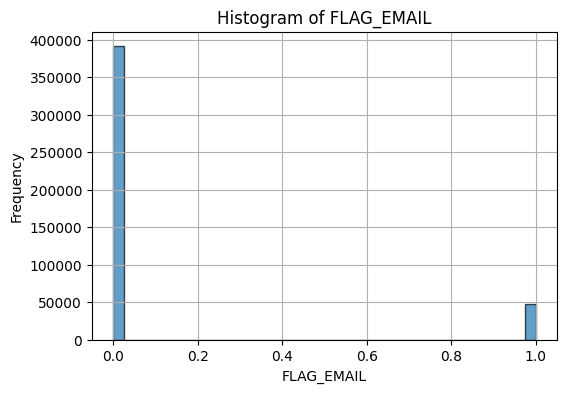

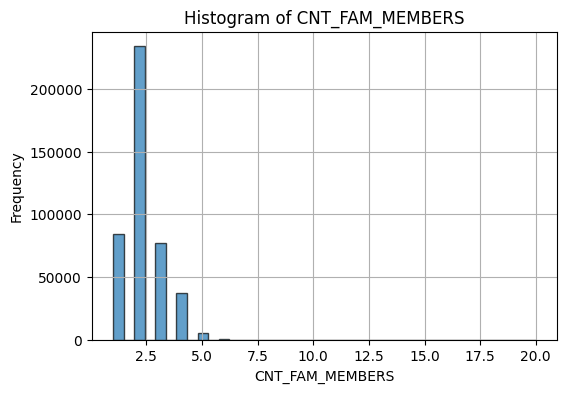

In [27]:
for col in app.select_dtypes(['float','int']):
    plt.figure(figsize=(6, 4))
    plt.hist(app[col], bins=40, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
plt.show()

<Figure size 600x400 with 0 Axes>

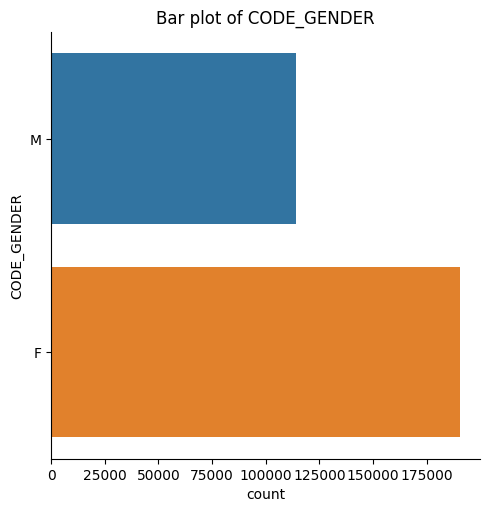

<Figure size 600x400 with 0 Axes>

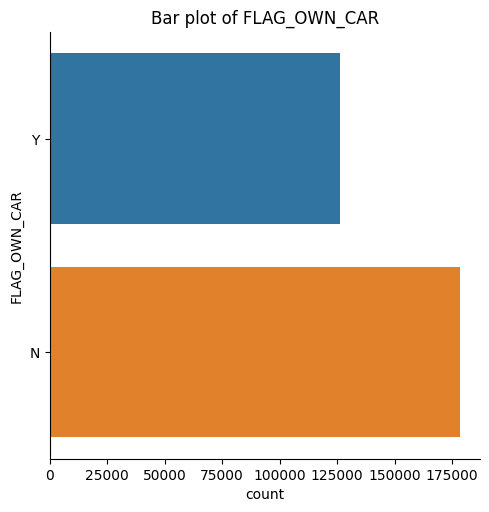

<Figure size 600x400 with 0 Axes>

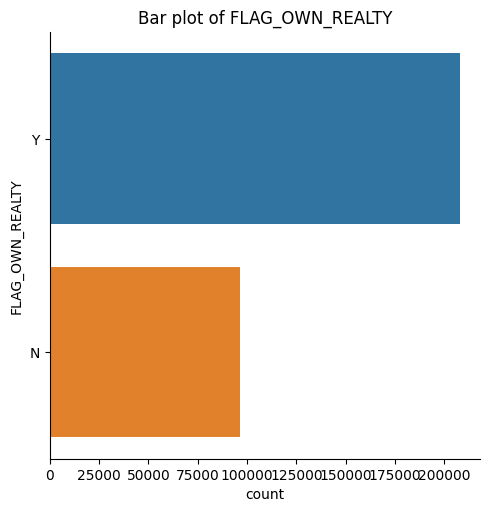

<Figure size 600x400 with 0 Axes>

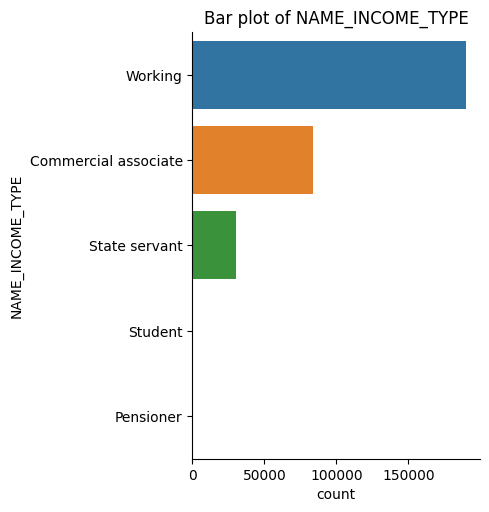

<Figure size 600x400 with 0 Axes>

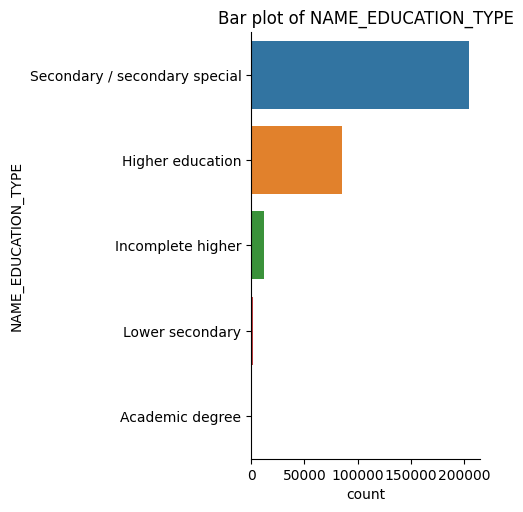

<Figure size 600x400 with 0 Axes>

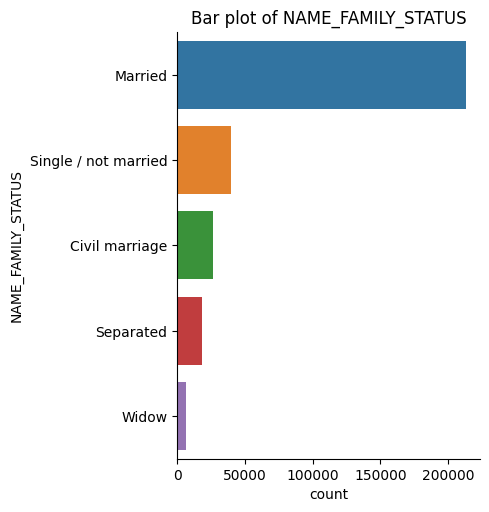

<Figure size 600x400 with 0 Axes>

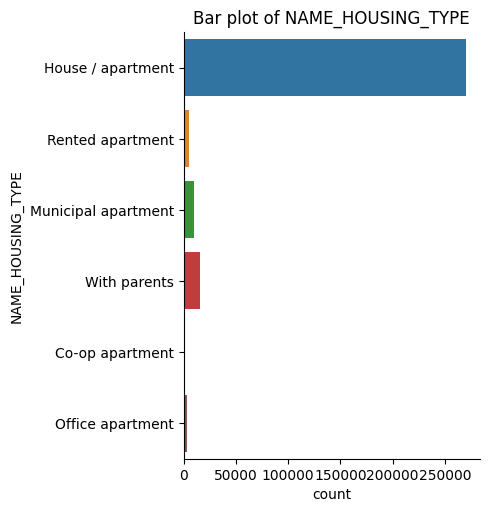

<Figure size 600x400 with 0 Axes>

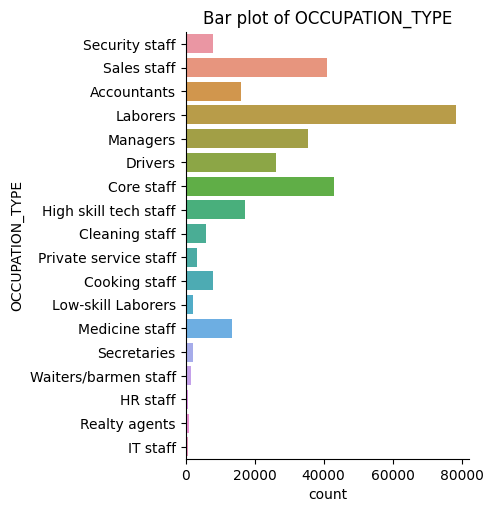

In [76]:
for col in app.select_dtypes(['object']):
    value_counts = app[col].value_counts()  # Get counts of each category
    plt.figure(figsize=(6, 4))
    sns.catplot(kind='count', data=app,y=col)
    plt.title(f'Bar plot of {col}')
    plt.show()

plt.show()

In [27]:
app.isna().sum()['OCCUPATION_TYPE'] / len(app) * 100

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438541,6837707,M,N,Y,0,202500.0,Working,Higher education,Civil marriage,House / apartment,-13510,-2309,1,1,0,0,Laborers,2.0
438548,6839936,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-12569,-2095,1,0,0,0,Laborers,3.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0


In [29]:
app = app.dropna()
app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304354 entries, 2 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   304354 non-null  int64  
 1   CODE_GENDER          304354 non-null  object 
 2   FLAG_OWN_CAR         304354 non-null  object 
 3   FLAG_OWN_REALTY      304354 non-null  object 
 4   CNT_CHILDREN         304354 non-null  int64  
 5   AMT_INCOME_TOTAL     304354 non-null  float64
 6   NAME_INCOME_TYPE     304354 non-null  object 
 7   NAME_EDUCATION_TYPE  304354 non-null  object 
 8   NAME_FAMILY_STATUS   304354 non-null  object 
 9   NAME_HOUSING_TYPE    304354 non-null  object 
 10  DAYS_BIRTH           304354 non-null  int64  
 11  DAYS_EMPLOYED        304354 non-null  int64  
 12  FLAG_MOBIL           304354 non-null  int64  
 13  FLAG_WORK_PHONE      304354 non-null  int64  
 14  FLAG_PHONE           304354 non-null  int64  
 15  FLAG_EMAIL           3

In [52]:
app.nunique()

ID                     304331
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               11
AMT_INCOME_TOTAL          645
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              14158
DAYS_EMPLOYED            8962
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            12
dtype: int64

# Data Preprocessing
---

## 1. Joining Dataframe

In [49]:
import warnings
warnings.filterwarnings('ignore')

# Filter by latest credit card 
credit_months=pd.DataFrame(credit.groupby(["ID"])["MONTHS_BALANCE"].agg('min'))
temp = pd.merge(app,credit_months,how="left",on="ID") 
credit_target= credit.groupby("ID").count()

# Encode dep_value
credit['dep_value'] = None
credit['dep_value'][credit['STATUS'] =='2']='Yes'
credit['dep_value'][credit['STATUS'] =='3']='Yes'
credit['dep_value'][credit['STATUS'] =='4']='Yes'
credit['dep_value'][credit['STATUS'] =='5']='Yes'

credit_target['dep_value'][credit_target['dep_value'] > 0]='Yes' 
credit_target['dep_value'][credit_target['dep_value'] == 0]='No' 
credit_target = credit_target[['dep_value']]
df=pd.merge(temp,credit_target,how='inner',on='ID')
df['STATUS']=df['dep_value']
df.loc[df['STATUS']=='Yes','STATUS'] = 1
df.loc[df['STATUS']=='No','STATUS'] = 0

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [24]:
df['STATUS'].value_counts(normalize=True)

STATUS
0    0.983103
1    0.016897
Name: proportion, dtype: float64

## 2. Information Value (pre-cleaned)

| IV	| Ability to predict |
|---|---|
| <0.02	|Almost no predictive power|
|0.02~0.1|	weak predictive power|
|0.1~0.3|	Moderate predictive power|
|0.3~0.5|	Strong predictive power|
|>0.5|	Predictive power is too strong, need to check variables|

In [43]:
# Calculate information value
def calc_iv(input, feature, target, pr=False):
    lst = []
    input[feature] = input[feature].fillna("NULL")

    for i in range(input[feature].nunique()):
        val = list(input[feature].unique())[i]
        lst.append([feature,                                                        
                    val,                                                            
                    input[input[feature] == val].count()[feature],                        
                    input[(input[feature] == val) & (input[target] == 0)].count()[feature], 
                    input[(input[feature] == val) & (input[target] == 1)].count()[feature]]) 

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(input[feature].value_counts())
    return iv, data

### Income

In [6]:
calc_iv(df, 'NAME_INCOME_TYPE', 'STATUS', pr=False)

This variable's IV is: 0.003787824102031537
NAME_INCOME_TYPE
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: count, dtype: int64


(0.003787824102031537,
            Variable                 Value    All  Good  Bad     Share  \
 0  NAME_INCOME_TYPE  Commercial associate   8490     0   73  0.232877   
 1  NAME_INCOME_TYPE             Pensioner   6152     0   54  0.168747   
 2  NAME_INCOME_TYPE         State servant   2985     0   30  0.081877   
 3  NAME_INCOME_TYPE               Student     11     0    0  0.000302   
 4  NAME_INCOME_TYPE               Working  18819     0  184  0.516197   
 
    Bad Rate  Distribution Good  Distribution Bad       WoE        IV  
 0  0.008598           0.233055          0.214076  0.084941  0.001612  
 1  0.008778           0.168845          0.158358  0.064123  0.000672  
 2  0.010050           0.081820          0.087977 -0.072552  0.000447  
 3  0.000000           0.000305          0.000000  0.000000  0.000000  
 4  0.009777           0.515976          0.539589 -0.044748  0.001057  )

### Gender

In [86]:
calc_iv(df, 'CODE_GENDER', 'STATUS', pr=False)

This variable's IV is: 0.0011874773087672706
CODE_GENDER
0    24430
1    12027
Name: count, dtype: int64


(0.0011874773087672706,
       Variable  Value    All  Good  Bad     Share  Bad Rate  \
 0  CODE_GENDER      0  24430     0  223  0.670105  0.009128   
 1  CODE_GENDER      1  12027     0  118  0.329895  0.009811   
 
    Distribution Good  Distribution Bad       WoE        IV  
 0           0.670257          0.653959  0.024617  0.000401  
 1           0.329743          0.346041 -0.048244  0.000786  )

### Housing Type

In [85]:
calc_iv(df, 'NAME_HOUSING_TYPE', 'STATUS', pr=False)

This variable's IV is: 0.0576390966849729
NAME_HOUSING_TYPE
House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: count, dtype: int64


(0.0576390966849729,
             Variable                Value    All  Good  Bad     Share  \
 0  NAME_HOUSING_TYPE      Co-op apartment    168     0    1  0.004608   
 1  NAME_HOUSING_TYPE    House / apartment  32548     0  292  0.892778   
 2  NAME_HOUSING_TYPE  Municipal apartment   1128     0    5  0.030941   
 3  NAME_HOUSING_TYPE     Office apartment    262     0    0  0.007187   
 4  NAME_HOUSING_TYPE     Rented apartment    575     0    9  0.015772   
 5  NAME_HOUSING_TYPE         With parents   1776     0   34  0.048715   
 
    Bad Rate  Distribution Good  Distribution Bad       WoE        IV  
 0  0.005952           0.004624          0.002933  0.455385  0.000770  
 1  0.008971           0.893122          0.856305  0.042097  0.001550  
 2  0.004433           0.031094          0.014663  0.751712  0.012352  
 3  0.000000           0.007254          0.000000  0.000000  0.000000  
 4  0.015652           0.015672          0.026393 -0.521239  0.005588  
 5  0.019144           0.04

### Own Car

In [88]:
calc_iv(df, 'FLAG_OWN_CAR', 'STATUS', pr=False)

This variable's IV is: 0.0161877164292711
FLAG_OWN_CAR
0    22614
1    13843
Name: count, dtype: int64


(0.0161877164292711,
        Variable  Value    All  Good  Bad     Share  Bad Rate  \
 0  FLAG_OWN_CAR      0  22614     0  232  0.620292  0.010259   
 1  FLAG_OWN_CAR      1  13843     0  109  0.379708  0.007874   
 
    Distribution Good  Distribution Bad       WoE        IV  
 0           0.619725          0.680352 -0.093334  0.005659  
 1           0.380275          0.319648  0.173673  0.010529  )

### Education

In [89]:
calc_iv(df, 'NAME_EDUCATION_TYPE', 'STATUS', pr=False)

This variable's IV is: 0.00514774857976666
NAME_EDUCATION_TYPE
1    24777
3     9864
2     1410
0      374
4       32
Name: count, dtype: int64


(0.00514774857976666,
               Variable  Value    All  Good  Bad     Share  Bad Rate  \
 0  NAME_EDUCATION_TYPE      0    374     0    2  0.010259  0.005348   
 1  NAME_EDUCATION_TYPE      1  24777     0  240  0.679623  0.009686   
 2  NAME_EDUCATION_TYPE      2   1410     0   11  0.038676  0.007801   
 3  NAME_EDUCATION_TYPE      3   9864     0   88  0.270565  0.008921   
 4  NAME_EDUCATION_TYPE      4     32     0    0  0.000878  0.000000   
 
    Distribution Good  Distribution Bad       WoE        IV  
 0           0.010300          0.005865  0.563138  0.002498  
 1           0.679394          0.703812 -0.035310  0.000862  
 2           0.038736          0.032258  0.183009  0.001186  
 3           0.270683          0.258065  0.047740  0.000602  
 4           0.000886          0.000000  0.000000  0.000000  )

### 

### Family Status

In [90]:
calc_iv(df, 'NAME_FAMILY_STATUS', 'STATUS', pr=False)

This variable's IV is: 0.02863526914926234
NAME_FAMILY_STATUS
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: count, dtype: int64


(0.02863526914926234,
              Variable                 Value    All  Good  Bad     Share  \
 0  NAME_FAMILY_STATUS        Civil marriage   2945     0   33  0.080780   
 1  NAME_FAMILY_STATUS               Married  25048     0  208  0.687056   
 2  NAME_FAMILY_STATUS             Separated   2103     0   23  0.057684   
 3  NAME_FAMILY_STATUS  Single / not married   4829     0   61  0.132457   
 4  NAME_FAMILY_STATUS                 Widow   1532     0   16  0.042022   
 
    Bad Rate  Distribution Good  Distribution Bad       WoE        IV  
 0  0.011205           0.080629          0.096774 -0.182521  0.002947  
 1  0.008304           0.687784          0.609971  0.120064  0.009343  
 2  0.010937           0.057592          0.067449 -0.157980  0.001557  
 3  0.012632           0.132019          0.178886 -0.303800  0.014238  
 4  0.010444           0.041976          0.046921 -0.111367  0.000551  )

## 3. Features Engineering

In [54]:
pd.qcut(app['AMT_INCOME_TOTAL'], q=3, labels=[0,1,2],retbins=True)

(0         2
 1         2
 2         0
 3         2
 4         2
          ..
 438552    0
 438553    0
 438554    0
 438555    0
 438556    0
 Name: AMT_INCOME_TOTAL, Length: 438557, dtype: category
 Categories (3, int64): [0 < 1 < 2],
 array([  26100.,  135000.,  202500., 6750000.]))

In [50]:
# Encode Income with low, medium and high
df['INCOME'], labels = pd.qcut(df['AMT_INCOME_TOTAL'], q=3, labels=[0,1,2],retbins=True)
df['INCOME'] = df['INCOME'].astype(int)

# Engineer Employment
df['EMPLOYMENT_YEARS'] = abs(df['DAYS_EMPLOYED']) / 365.25
df['EMPLOYMENT_STATUS'] = np.where(df['DAYS_EMPLOYED'] > 0, 'Unemployed', 'Employed')

# Encode Age
df['AGE'] = -1 * df['DAYS_BIRTH'] // 365
df['AGE_GROUP'] = pd.cut(df['AGE'], 
    bins=[0, 25, 35, 45, 55, 100], 
    labels=[0,1,2,3,4]).astype(int)

# Encode Months Active
df['MONTHS_BALANCE'] = -1 * df['MONTHS_BALANCE']

# Engineer Occupation 
df.loc[(df['OCCUPATION_TYPE']=='Cleaning staff') | (df['OCCUPATION_TYPE']=='Cooking staff') | (df['OCCUPATION_TYPE']=='Drivers') | (df['OCCUPATION_TYPE']=='Laborers') | (df['OCCUPATION_TYPE']=='Low-skill Laborers') | (df['OCCUPATION_TYPE']=='Security staff') | (df['OCCUPATION_TYPE']=='Waiters/barmen staff'),'OCCUPATION_TYPE']='LABOR'
df.loc[(df['OCCUPATION_TYPE']=='Accountants') | (df['OCCUPATION_TYPE']=='Core staff') | (df['OCCUPATION_TYPE']=='HR staff') | (df['OCCUPATION_TYPE']=='Medicine staff') | (df['OCCUPATION_TYPE']=='Private service staff') | (df['OCCUPATION_TYPE']=='Realty agents') | (df['OCCUPATION_TYPE']=='Sales staff') | (df['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE']='OFFICE'
df.loc[(df['OCCUPATION_TYPE']=='Managers') | (df['OCCUPATION_TYPE']=='High skill tech staff') | (df['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE']='HIGHPOSITION'

# Engineer Income Type
df.loc[df['NAME_INCOME_TYPE']=='Pensioner','NAME_INCOME_TYPE']='State servant'
df.loc[df['NAME_INCOME_TYPE']=='Student','NAME_INCOME_TYPE']='State servant'

# Engineer Education
df.loc[df['NAME_EDUCATION_TYPE']=='Academic degree','NAME_EDUCATION_TYPE']='Higher education'

engineered_cols = ['AGE', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL','MONTHS_BALANCE']

## 4. Encode

In [51]:
# Encode Education (ordinal)
education_map = {'Lower secondary':0,
                'Secondary / secondary special' : 1,
                'Incomplete higher': 2,
                'Higher education' : 3,
                }
if df['NAME_EDUCATION_TYPE'].dtype == 'object':
    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_map).astype('int')

# Encode Binary Features
label = LabelEncoder()
for col in df.columns[df.nunique() == 2]:
    df[col] = label.fit_transform(df[col]).astype(int)

# One Hot Encoding
def oneHot(input,col):
    df = pd.concat([input, pd.get_dummies(input[col],prefix=col).astype(int)],axis=1)
    return df
    
object_cols = df.select_dtypes('object').columns
for col in object_cols:
    df = oneHot(df,col)

df = df.drop(['dep_value','ID','FLAG_MOBIL']+object_cols.tolist()+engineered_cols,axis=1)    
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   CODE_GENDER                              36457 non-null  int64  
 1   FLAG_OWN_CAR                             36457 non-null  int64  
 2   FLAG_OWN_REALTY                          36457 non-null  int64  
 3   CNT_CHILDREN                             36457 non-null  int64  
 4   NAME_EDUCATION_TYPE                      36457 non-null  int64  
 5   FLAG_WORK_PHONE                          36457 non-null  int64  
 6   FLAG_PHONE                               36457 non-null  int64  
 7   FLAG_EMAIL                               36457 non-null  int64  
 8   CNT_FAM_MEMBERS                          36457 non-null  float64
 9   STATUS                                   36457 non-null  int64  
 10  INCOME                                   36457

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS,INCOME,EMPLOYMENT_YEARS,EMPLOYMENT_STATUS,AGE_GROUP,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_HIGHPOSITION,OCCUPATION_TYPE_LABOR,OCCUPATION_TYPE_OFFICE
0,1,1,1,0,3,1,0,0,2.0,0,2,12.435318,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,1,0,3,1,0,0,2.0,0,2,12.435318,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0,1,0,0,0,2.0,0,0,3.104723,0,4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,0,0,1,0,1,0,1,1,1.0,0,2,8.353183,0,3,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,0,0,1,0,1,0,1,1,1.0,0,2,8.353183,0,3,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


<Axes: >

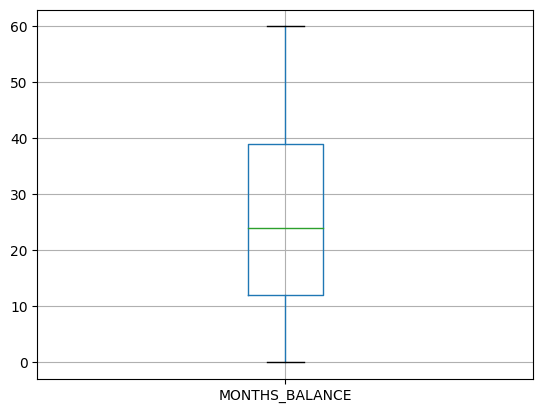

In [48]:
df.boxplot('MONTHS_BALANCE')

## 5. Information Value (post-cleaned)

In [43]:
df = df.drop([
    'DAYS_BIRTH',
    'AMT_INCOME_TOTAL'],axis=1,errors='ignore')
df = df.drop(object_cols,axis=1,errors='ignore')
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_EDUCATION_TYPE,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,INCOME,AGE,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_HIGHPOSITION,OCCUPATION_TYPE_LABOR,OCCUPATION_TYPE_OFFICE
0,5008804,1,1,1,0,3,-4542,1,1,0,0,2.0,15.0,16,2,32,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5008805,1,1,1,0,3,-4542,1,1,0,0,2.0,14.0,15,2,32,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5008806,1,1,1,0,1,-1134,1,0,0,0,2.0,29.0,30,0,58,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,5008808,0,0,1,0,1,-3051,1,0,1,1,1.0,4.0,5,2,52,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,5008809,0,0,1,0,1,-3051,1,0,1,1,1.0,26.0,5,2,52,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


<Figure size 600x400 with 0 Axes>

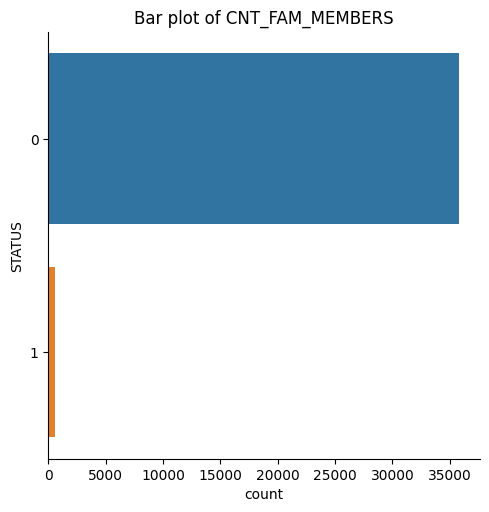

In [62]:
value_counts = df['STATUS'].value_counts()  # Get counts of each category
plt.figure(figsize=(6, 4))
sns.catplot(kind='count', data=df,y='STATUS')
plt.title(f'Bar plot of {col}')
plt.show()

plt.show()

# Modelling
---

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Assuming train_clean is your DataFrame
X = df.drop(['STATUS'], axis=1)
y = df['STATUS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

# Oversampling
os = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = os.fit_resample(X_train, y_train)

## XGBoost

In [66]:
model = XGBClassifier(seed=RANDOM_STATE)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8961
           1       0.13      0.38      0.20       154

    accuracy                           0.95      9115
   macro avg       0.56      0.67      0.58      9115
weighted avg       0.97      0.95      0.96      9115

      0    1
0  8581  380
1    96   58


## Random Forest

In [44]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

      0    1
0  8725  236
1   132   22


## CatBoost

In [60]:
# Model with no params
model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.056473
0:	learn: 0.6789486	total: 9.32ms	remaining: 9.31s
1:	learn: 0.6637800	total: 18.3ms	remaining: 9.13s
2:	learn: 0.6507986	total: 27.4ms	remaining: 9.1s
3:	learn: 0.6400330	total: 36.4ms	remaining: 9.06s
4:	learn: 0.6297881	total: 46.1ms	remaining: 9.18s
5:	learn: 0.6216754	total: 55ms	remaining: 9.11s
6:	learn: 0.6135474	total: 63.8ms	remaining: 9.05s
7:	learn: 0.5928542	total: 72.9ms	remaining: 9.04s
8:	learn: 0.5850692	total: 81.7ms	remaining: 8.99s
9:	learn: 0.5784156	total: 90.7ms	remaining: 8.98s
10:	learn: 0.5583456	total: 99.5ms	remaining: 8.95s
11:	learn: 0.5519275	total: 108ms	remaining: 8.9s
12:	learn: 0.5458678	total: 117ms	remaining: 8.88s
13:	learn: 0.5407974	total: 126ms	remaining: 8.85s
14:	learn: 0.5231103	total: 135ms	remaining: 8.84s
15:	learn: 0.5175807	total: 144ms	remaining: 8.83s
16:	learn: 0.5126866	total: 153ms	remaining: 8.83s
17:	learn: 0.5075802	total: 162ms	remaining: 8.82s
18:	learn: 0.5021543	total: 171ms	remaining: 8.82s
19:	

In [68]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8961
           1       0.12      0.36      0.18       154

    accuracy                           0.95      9115
   macro avg       0.56      0.66      0.58      9115
weighted avg       0.97      0.95      0.96      9115



In [67]:
# Method 1: Native CatBoost Save
def save_catboost_model(model, filename='catboost_model.cbm'):
    model.save_model(filename)

def load_catboost_model(filename='catboost_model.cbm'):
    model = CatBoostClassifier()
    model.load_model(filename)
    return model

save_catboost_model(model)